In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic

In [6]:
# Load the loan data
loan_all_df = pd.read_csv("loan.csv", low_memory=False)
loan_all_df.shape

(39717, 111)

In [7]:
loan_all_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,...,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,...,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,...,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
75%,8.377550e+05,1.047339e+06,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,...,NaN,NaN,NaN,NaN,2.000000,0.0,NaN,NaN,NaN,NaN


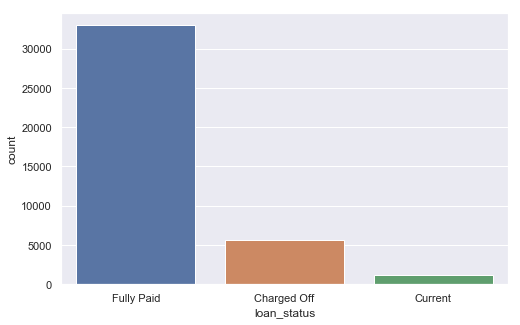

In [8]:
sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(loan_all_df.loan_status)

In [9]:
# Keep only the rows where loan_status is not Current
loan_df = loan_all_df.loc[loan_all_df.loan_status != 'Current']
loan_df.shape

(38577, 111)

## Data Sanity Checks

In [10]:
# Find out percentage of missing values in each column
columns = loan_df.columns
percent_missing = loan_df.isnull().sum() * 100 / len(loan_df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False, inplace=True)
missing_value_df[missing_value_df.percent_missing == 100]

,column_name,percent_missing
verification_status_joint,verification_status_joint,100.0
annual_inc_joint,annual_inc_joint,100.0
mo_sin_old_rev_tl_op,mo_sin_old_rev_tl_op,100.0
mo_sin_old_il_acct,mo_sin_old_il_acct,100.0
bc_util,bc_util,100.0
bc_open_to_buy,bc_open_to_buy,100.0
avg_cur_bal,avg_cur_bal,100.0
acc_open_past_24mths,acc_open_past_24mths,100.0
inq_last_12m,inq_last_12m,100.0
total_cu_tl,total_cu_tl,100.0


In [11]:
# list the columns that have 100% missing values
list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name'])

['verification_status_joint',
 'annual_inc_joint',
 'mo_sin_old_rev_tl_op',
 'mo_sin_old_il_acct',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'inq_last_12m',
 'total_cu_tl',
 'inq_fi',
 'total_rev_hi_lim',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'tot_cur_bal',
 'tot_coll_amt',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'total_bal_ex_mort',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_sats',
 'num_rev_accts',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_il_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'num_accts_ever_120_pd',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_inq',
 'mths_since_recent_bc_dlq',
 'dti_joint',
 '

In [12]:
# drop columns that have 100% mising values
loan_df.drop(columns=list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name']),inplace = True)
loan_df.shape

C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(38577, 56)

In [13]:
# find out columns that have 0 standard deviation
loan_df.std()[loan_df.std() == 0]

out_prncp                     0.0
out_prncp_inv                 0.0
collections_12_mths_ex_med    0.0
policy_code                   0.0
acc_now_delinq                0.0
chargeoff_within_12_mths      0.0
delinq_amnt                   0.0
tax_liens                     0.0
dtype: float64

In [14]:
# dropping column with standard deviation 0
loan_df.drop(loan_df.std()[loan_df.std() == 0.0].index.values, axis=1,inplace = True)
loan_df.shape

(38577, 48)

In [15]:
# checking whether there are columns having single values. Standard deviation check will not work for non-numeric columns
uniques = loan_df.apply(lambda x: x.nunique())
uniques[uniques==1]

pymnt_plan             1
initial_list_status    1
application_type       1
dtype: int64

In [16]:
# dropping columns having single values
loan_df = loan_df.drop(uniques[uniques==1].index, axis=1)
loan_df.shape

(38577, 45)

## Business Understanding

In [17]:
# Drop columns that will not be available at the time of aproving loan
columns_to_remove = ['last_credit_pull_d',
                     'last_pymnt_amnt',
                    'collection_recovery_fee',
                     'delinq_2yrs',
                     'mths_since_last_delinq',
                     'last_pymnt_d',
                     'recoveries',
                     'total_pymnt',
                     'total_pymnt_inv',
                     'total_rec_int',
                     'total_rec_late_fee',
                     'total_rec_prncp'
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 33)

## Data Understanding

In [18]:
# Drop columns that will can not have any impact
columns_to_remove = ['title' , # very high variance
                     'emp_title' # very high variance
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 31)

In [19]:
# checking whether there are duplicate rows
loan_df.duplicated().sum()

0

In [20]:
# Check potential unique value fields 
df_colunique = pd.DataFrame(loan_df.nunique()/loan_df.count())
# Columns having all unique values excludeing Nulls
df_colunique.loc[df_colunique[0] >= 0.99]

,0
id,1.000000
member_id,1.000000
url,1.000000
desc,0.990518


In [21]:
# drop the columns where each row has unique values
loan_df.drop(df_colunique.loc[df_colunique[0] >= 0.99].index, axis=1, inplace= True)
loan_df.shape

(38577, 27)

In [22]:
# Strip all columns for leading and lagging spaces

loan_df = loan_df.applymap(lambda s : s.strip() if type(s) is str else s)

In [23]:
# Remove string months from term 6 

loan_df.term = loan_df.term.apply(lambda s : s[0:s.index(' ')] if ' ' in s else s)
loan_df.term = pd.to_numeric(loan_df.term)
loan_df.term.head()

0    36
1    60
2    36
3    36
5    36
Name: term, dtype: int64

In [24]:
# Remove % sign from interest rate 
loan_df.int_rate = loan_df.int_rate.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.int_rate = pd.to_numeric(loan_df.int_rate)
loan_df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: float64

In [25]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 27 columns):
loan_amnt                 38577 non-null int64
funded_amnt               38577 non-null int64
funded_amnt_inv           38577 non-null float64
term                      38577 non-null int64
int_rate                  38577 non-null float64
installment               38577 non-null float64
grade                     38577 non-null object
sub_grade                 38577 non-null object
emp_length                37544 non-null object
home_ownership            38577 non-null object
annual_inc                38577 non-null float64
verification_status       38577 non-null object
issue_d                   38577 non-null object
loan_status               38577 non-null object
purpose                   38577 non-null object
zip_code                  38577 non-null object
addr_state                38577 non-null object
dti                       38577 non-null float64
earliest_cr_line         

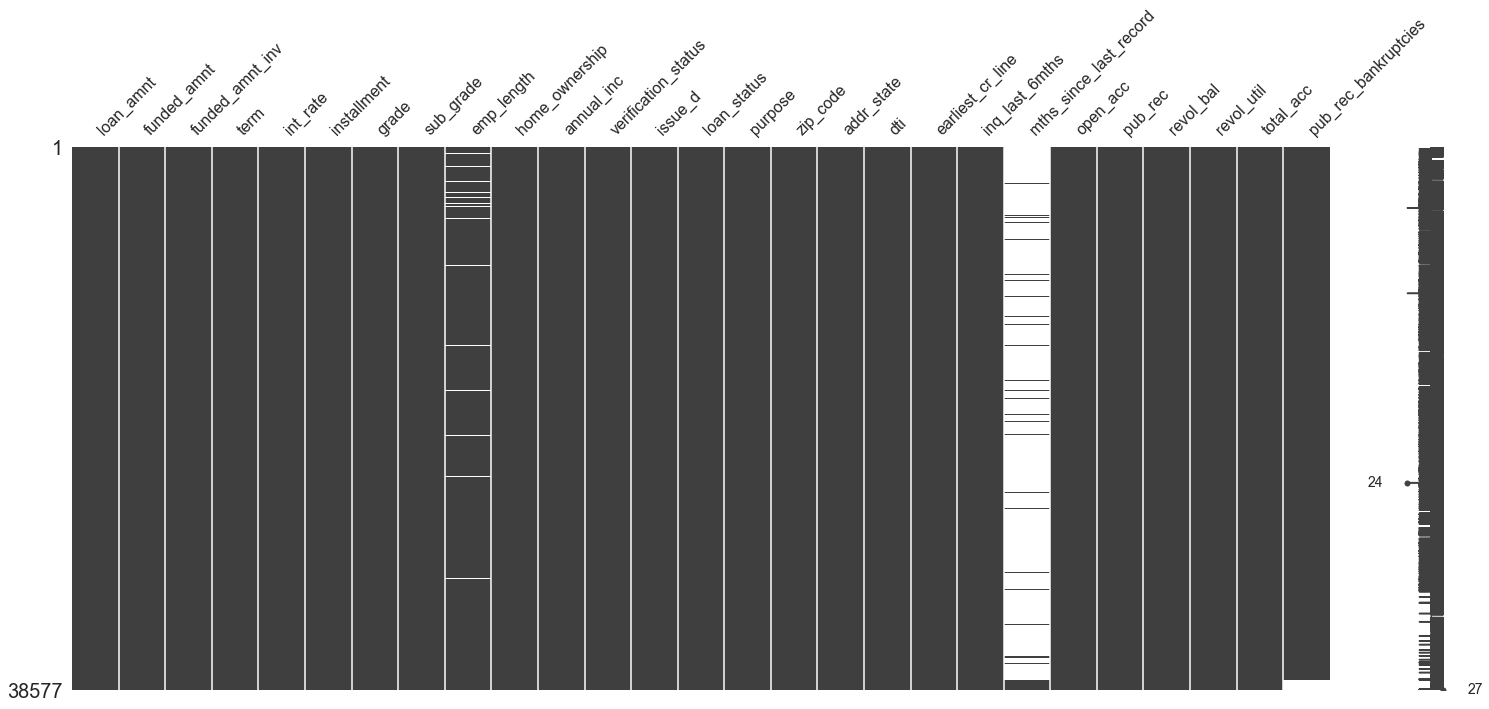

In [26]:
# visualize missing data
msno.matrix(loan_df)

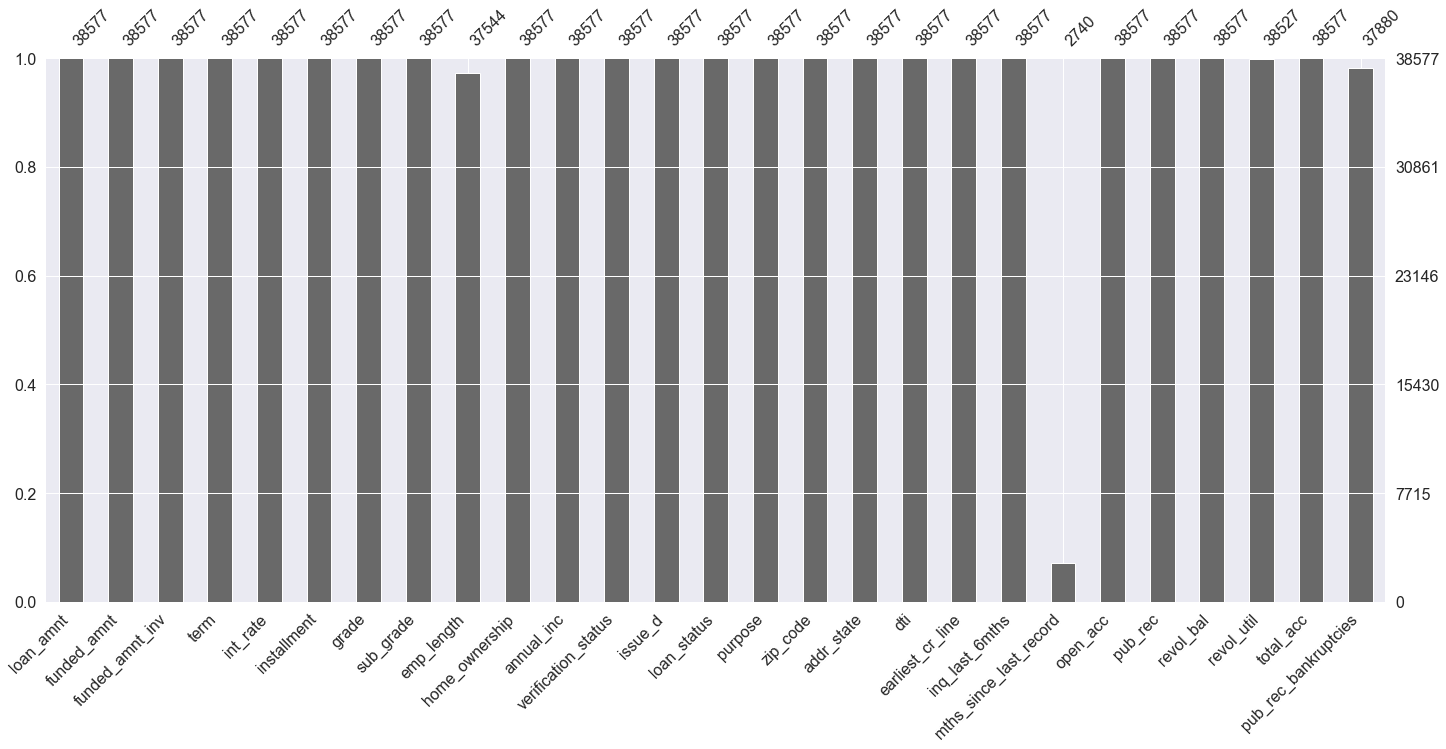

In [27]:
msno.bar(loan_df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

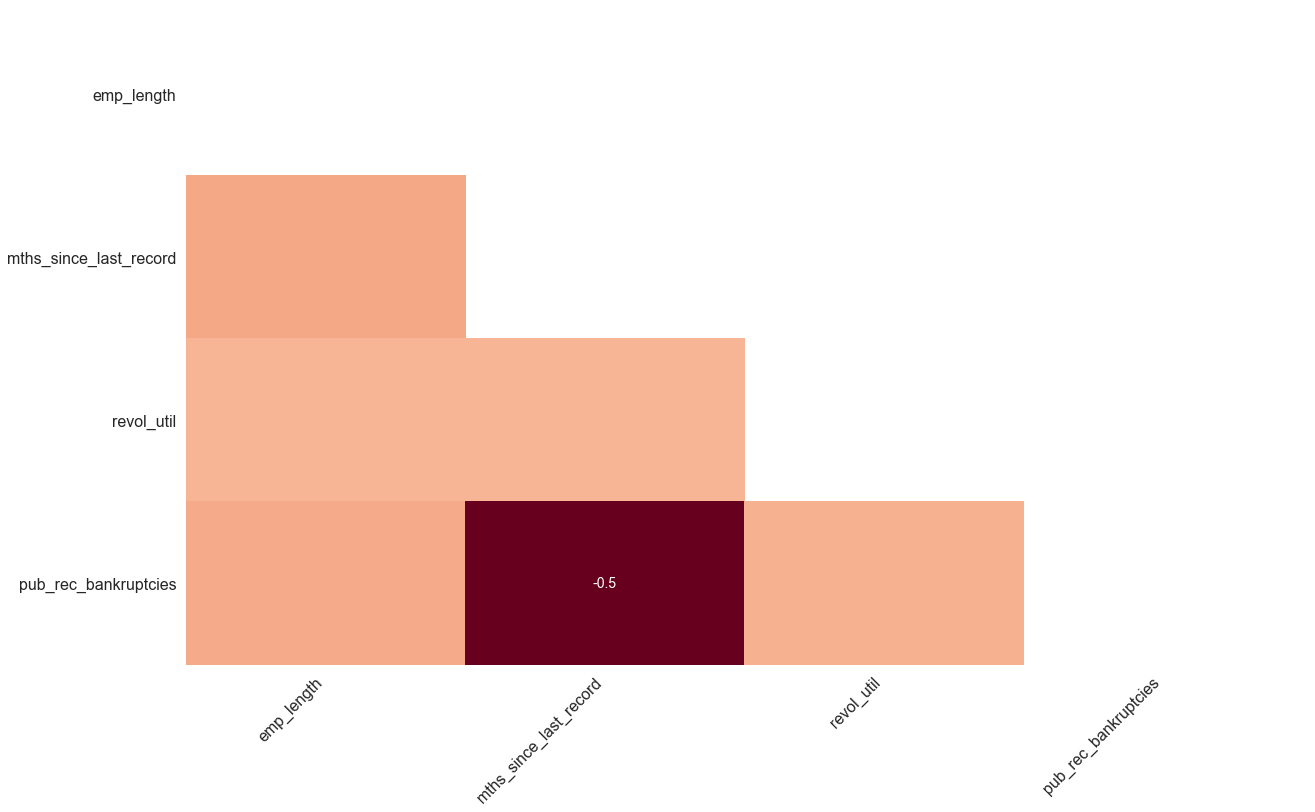

In [28]:
msno.heatmap(loan_df)

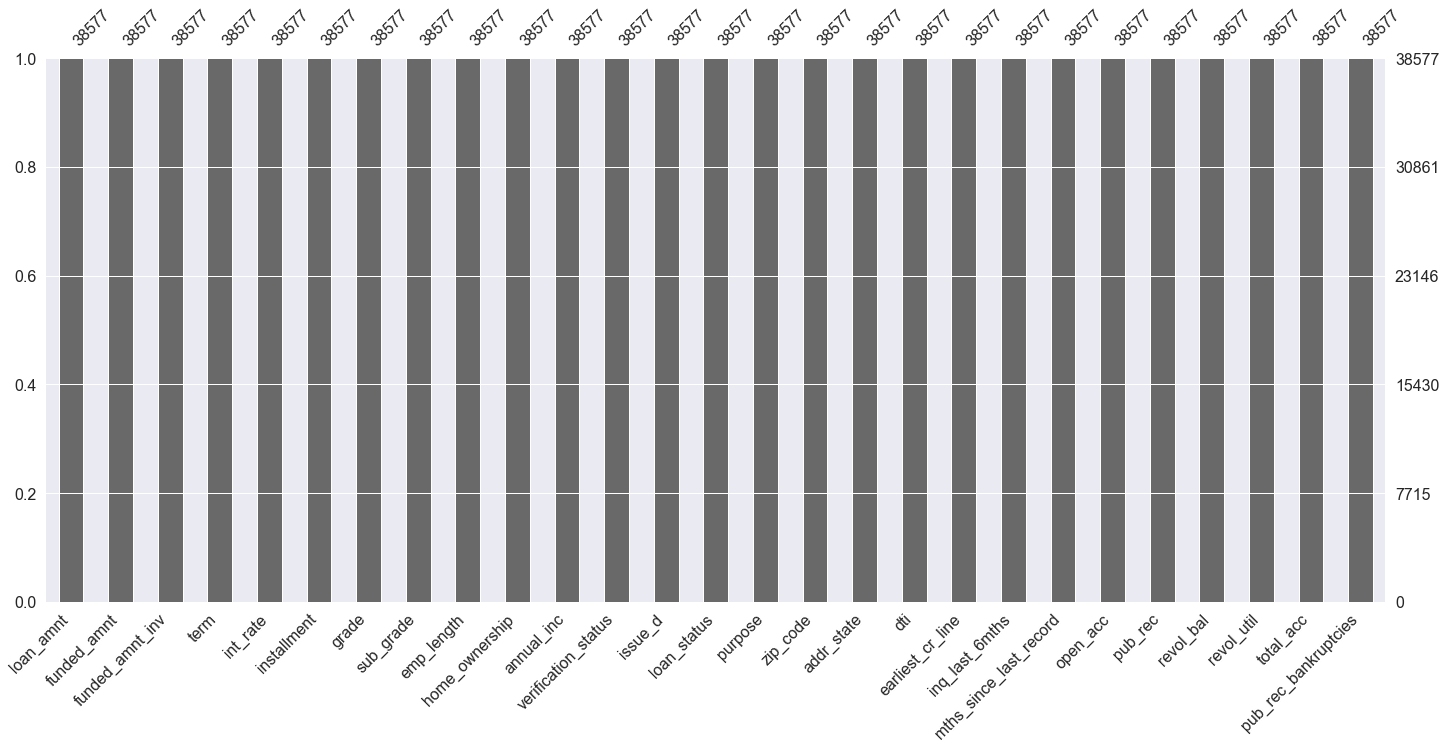

In [29]:
# Impute missing values
values = {'emp_length': 'NA', 'revol_util': '0%', 'mths_since_last_record': -1, 'pub_rec_bankruptcies':0}
loan_df.fillna(value=values, inplace = True)
msno.bar(loan_df)

In [30]:
# Remove % sign from interest rate 
loan_df.revol_util = loan_df.revol_util.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.revol_util = pd.to_numeric(loan_df.revol_util)
loan_df.revol_util.head()

0    83.7
1     9.4
2    98.5
3    21.0
5    28.3
Name: revol_util, dtype: float64

In [31]:
# writing load data frame with reduced columns in a csv
loan_df.to_csv('loan_df_reduced.csv')

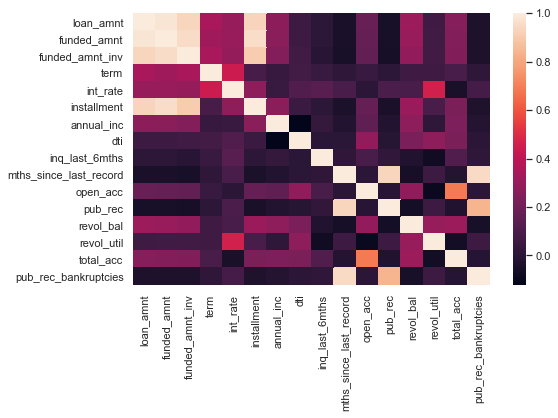

In [32]:
# this is correlation plot for all numeric variables
sns.heatmap(loan_df.corr())

In [33]:
loan_df.corr().style.background_gradient()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,inq_last_6mths,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
loan_amnt,1,0.98179,0.937922,0.34665,0.301265,0.93226,0.268999,0.0624358,0.01294,-0.0440968,0.1772,-0.0499975,0.314022,0.065247,0.256179,-0.0351408
funded_amnt,0.98179,1,0.956172,0.324893,0.30493,0.958035,0.264798,0.0621941,0.0128569,-0.0450441,0.175682,-0.0505762,0.306501,0.0690917,0.250551,-0.0361889
funded_amnt_inv,0.937922,0.956172,1,0.343922,0.297473,0.905464,0.251981,0.070663,-0.00280027,-0.0471814,0.162738,-0.0514702,0.286265,0.0740798,0.242715,-0.036327
term,0.34665,0.324893,0.343922,1,0.440206,0.0904558,0.0438658,0.076182,0.0477079,0.0148981,0.0461625,0.0102661,0.0664109,0.0666585,0.0961683,0.0166903
int_rate,0.301265,0.30493,0.297473,0.440206,1,0.277203,0.0488991,0.110913,0.133362,0.0942669,0.00602205,0.0986354,0.0941787,0.463627,-0.046539,0.0840158
installment,0.93226,0.958035,0.905464,0.0904558,0.277203,1,0.267842,0.0520385,0.0110144,-0.0411206,0.172893,-0.0457055,0.309501,0.0945593,0.22986,-0.0330383
annual_inc,0.268999,0.264798,0.251981,0.0438658,0.0488991,0.267842,1,-0.12153,0.0354651,-0.0176706,0.156927,-0.017864,0.277374,0.0174974,0.234534,-0.0159546
dti,0.0624358,0.0621941,0.070663,0.076182,0.110913,0.0520385,-0.12153,1,0.00217837,0.00437102,0.287849,-0.00474244,0.22809,0.279091,0.229119,0.00731548
inq_last_6mths,0.01294,0.0128569,-0.00280027,0.0477079,0.133362,0.0110144,0.0354651,0.00217837,1,0.0209267,0.0934343,0.0237263,-0.020787,-0.0700162,0.113516,0.014821
mths_since_last_record,-0.0440968,-0.0450441,-0.0471814,0.0148981,0.0942669,-0.0411206,-0.0176706,0.00437102,0.0209267,1,0.00609323,0.935876,-0.0543542,0.061781,-0.0162151,0.951221


In [34]:
# find columns where they have absolute correlation greater than 0.5 with some other column
corr_matrix = loan_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_keep_col = [column for column in upper.columns if any(upper.loc[:,column] >=0.5)]
to_keep_row = [row for row in upper.index if any(upper.loc[row,:] >=0.5)]
to_keep = list(set(to_keep_col).union(set(to_keep_row)))
to_keep

['pub_rec',
 'installment',
 'open_acc',
 'total_acc',
 'funded_amnt',
 'loan_amnt',
 'pub_rec_bankruptcies',
 'funded_amnt_inv',
 'mths_since_last_record']

Lets Focus on these highly correlated columns to derive new features.

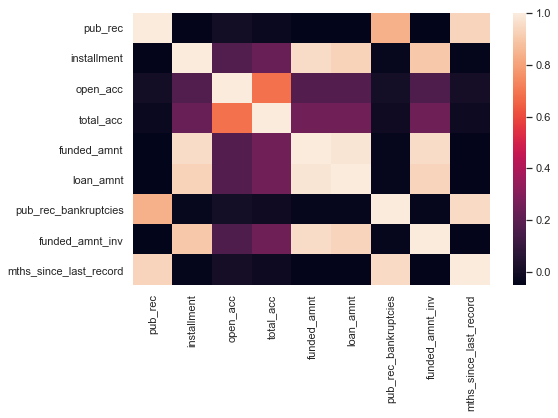

In [35]:
#subset dataframe on highly correlated columns
loan_high_corr_df = loan_df.loc[:,to_keep]
sns.heatmap(loan_high_corr_df.corr())

In [36]:
# pairwise plot - commented as it is making notebook heavy
# sns.pairplot(loan_high_corr_df)

In [143]:
# Perform Univariate Analysis

# Write Function to perform univariate analysis on categorical variables 

def uni_analysis_cat (x , summary = 0):
    sns.set(rc={'figure.figsize':(15,6)})
    x.iloc[:,0].value_counts().plot(kind='barh')
    f, axes = plt.subplots(1, 2)
       
    if(~summary):
        print(x.iloc[:,0].value_counts())
        sns.countplot( x = x.iloc[:,0], data = x , ax = axes[0])
        #plt.xticks(rotation=90)
        sns.countplot( x = x.iloc[:,0], hue = x.iloc[:,1] , data = x , ax = axes[1] )
        #plt.xticks(rotation=90)
        for ax in f.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        print('****************************************************************************************************')
        #ctab = pd.crosstab(x.iloc[:,1] ,x.iloc[:,0] , margins = False ,\
        #                   margins_name = 'Total' , normalize = True).round(4) * 100
        
        # plot the heat map for the cross tab 
        #fm , main = plt.subplots()
        #sns.heatmap(ctab ,cmap = 'Greens' , annot = True)
        labelizer = lambda k: ''
        mosaic(x.sort_values(list(x.columns)[0]),
               list(x.columns),
               label_rotation = [90,0], 
               labelizer=labelizer)

In [95]:
# Univariate analysis for quantitative variable 


def uni_analysis_num (x , type = 'r'):
    sns.set(rc={'figure.figsize':(15,6)})
    f, axes = plt.subplots(1, 3)
    
    print('Variable =' , x.columns[0])
    print('Mean Value ', round(x.iloc[:,0].mean(),2) )
    print('Median ', round(x.iloc[:,0].median(),2) )
   
    print('****************************************************************************************************')
    # print(x.iloc[:,0].value_counts())
    #sns.distplot(x.iloc[:,0])
    # for each unique value in 2nd column
    for value in list(x.iloc[:,1].unique()):
        a = x.loc[x.iloc[:,1] == value,list(x.columns)[0]]
        a.rename(index = value, inplace = True)
        p1=sns.kdeplot(a, shade=True)
    #p1=sns.kdeplot(charged_off, shade=True, color="b")
    sns.boxplot( y = x.iloc[:,0], data = x , ax = axes[0])
    sns.violinplot( x = x.iloc[:,1] , y = x.iloc[:,0] , data = x , ax = axes[1], \
                   vert = True , inner = 'quartile' ,scale_hue = True )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #print('****************************************************************************************************')
    #print(pd.crosstab(x.iloc[:,0] ,x.iloc[:,1] , margins = True , margins_name = 'Total' , normalize = True).round(4) * 100)

In [39]:
def bubble_plot(x , y , z ,percent):
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(10, 6))
    
    plt.scatter(x = x
                , y = y , 
                s = percent * 100,
                c = 'r',
               alpha = 0.8)

    
    for i in range(0,len(x)):
        plt.text(x[i] ,y[i], s= percent[i].round(2) , ha = 'left', va = 'center', fontsize = 12)

    plt.show()

### revol_bal

Variable = revol_bal
Mean Value  13289.49
Median  8762.0
****************************************************************************************************


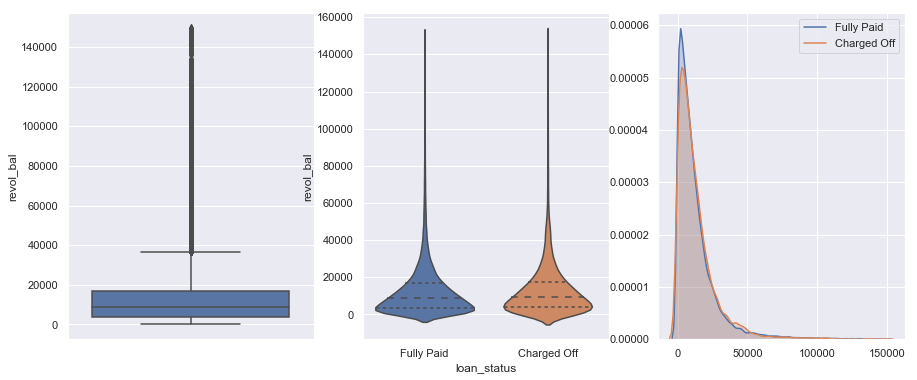

In [98]:
uni_analysis_num(loan_df[['revol_bal', 'loan_status']])

### int_rate

Variable = int_rate
Mean Value  11.93
Median  11.71
****************************************************************************************************


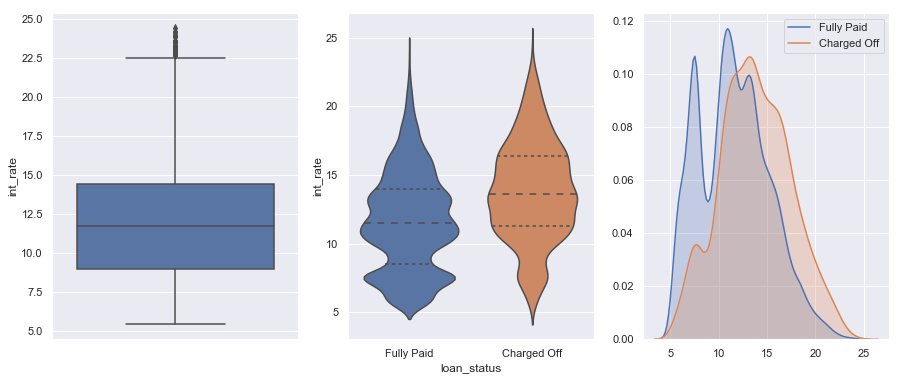

In [99]:
uni_analysis_num(loan_df[['int_rate' , 'loan_status']])

### revol_util

Variable = revol_util
Mean Value  48.64
Median  49.0
****************************************************************************************************


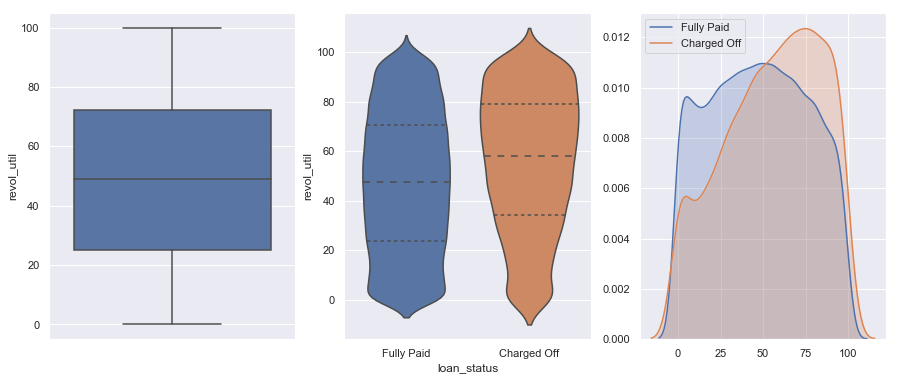

In [96]:
uni_analysis_num(loan_df[['revol_util' , 'loan_status']])


Variable = revol_util_norm
Mean Value  0.0
Median  0.01
****************************************************************************************************


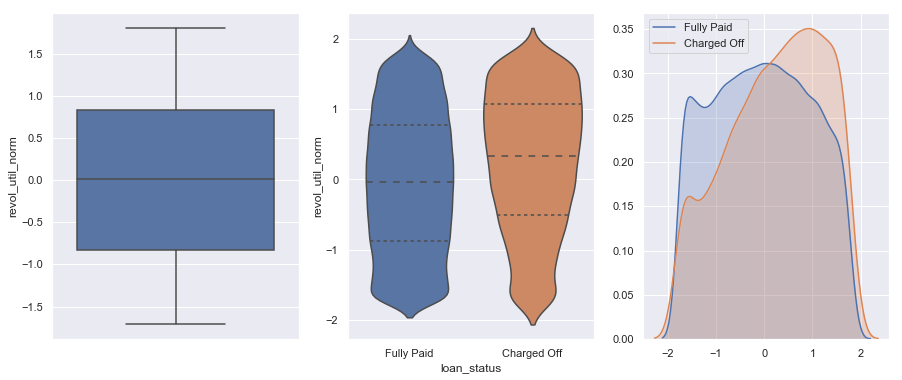

In [97]:
loan_df.loc[:,'revol_util_norm'] = (loan_df.revol_util - loan_df.revol_util.mean())/loan_df.revol_util.std()
uni_analysis_num(loan_df[['revol_util_norm' , 'loan_status']])

### sub_grade

A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: sub_grade, dtype: int64
****************************************************************************************************


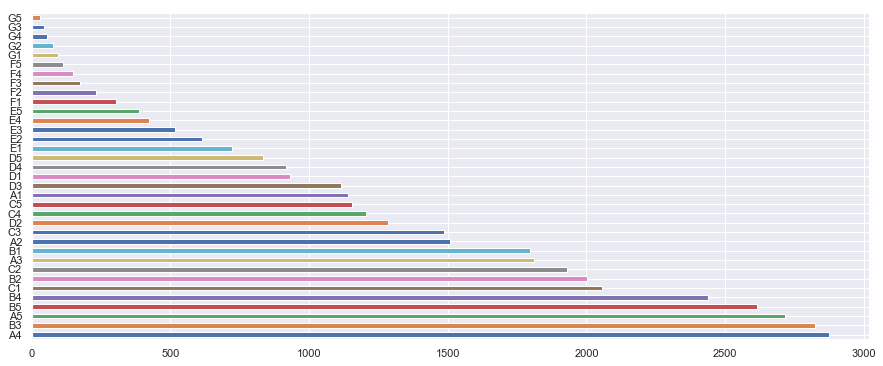

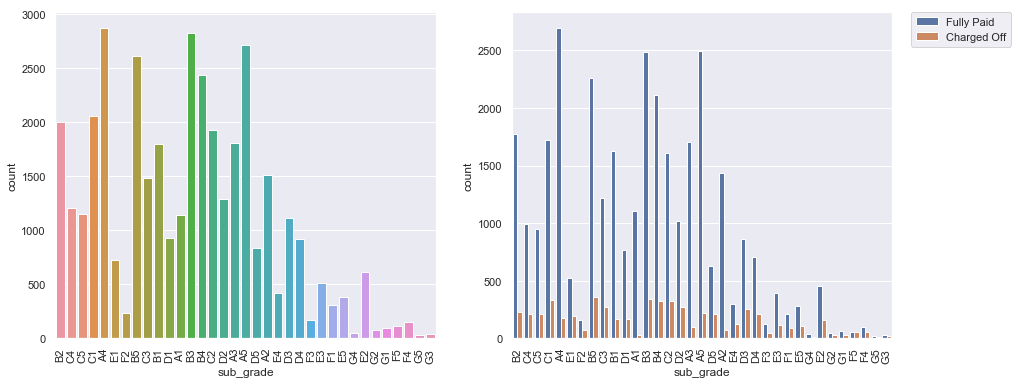

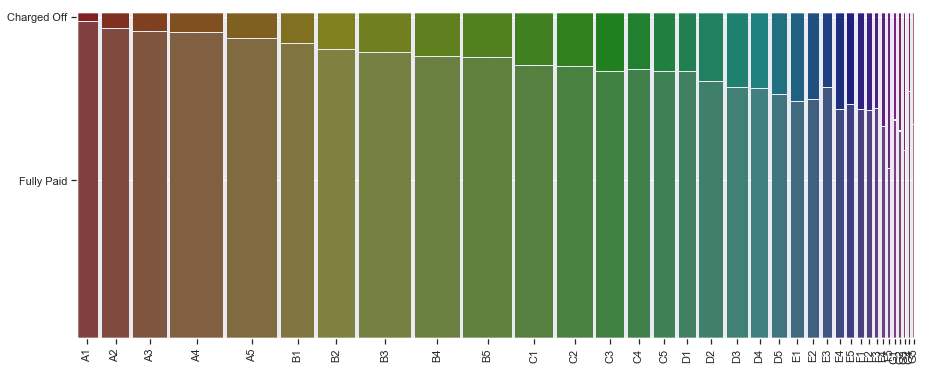

In [144]:
uni_analysis_cat(loan_df[['sub_grade' , 'loan_status']] , summary = True)

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64
****************************************************************************************************


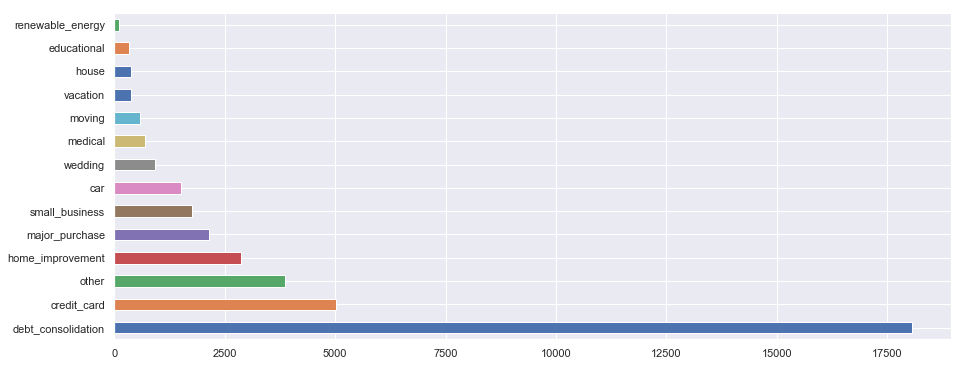

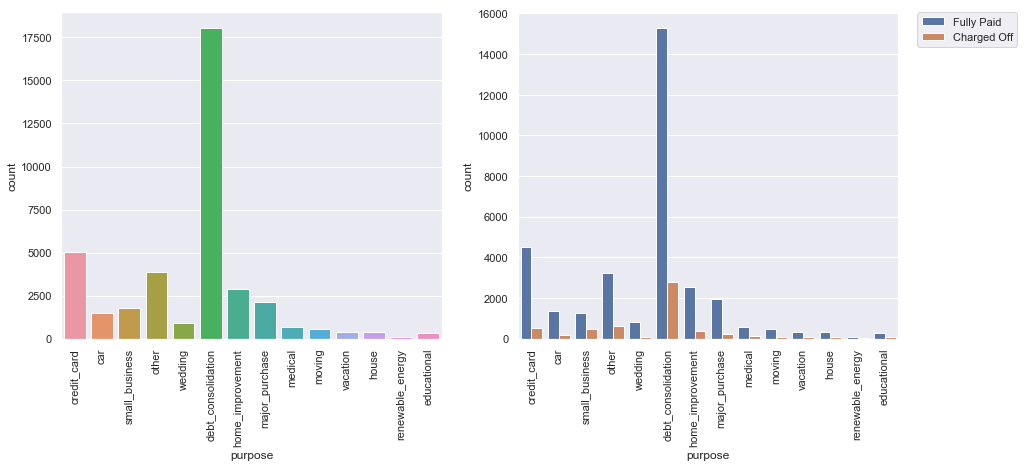

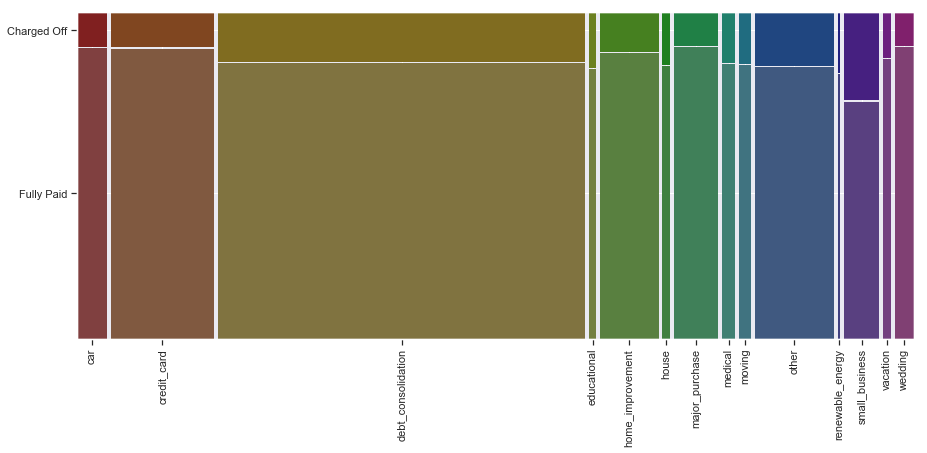

In [145]:
uni_analysis_cat(loan_df[['purpose' , 'loan_status']] , summary = True)

0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64
****************************************************************************************************


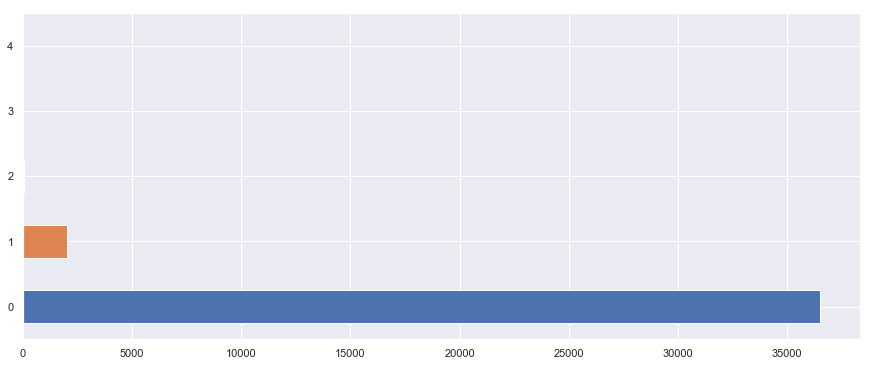

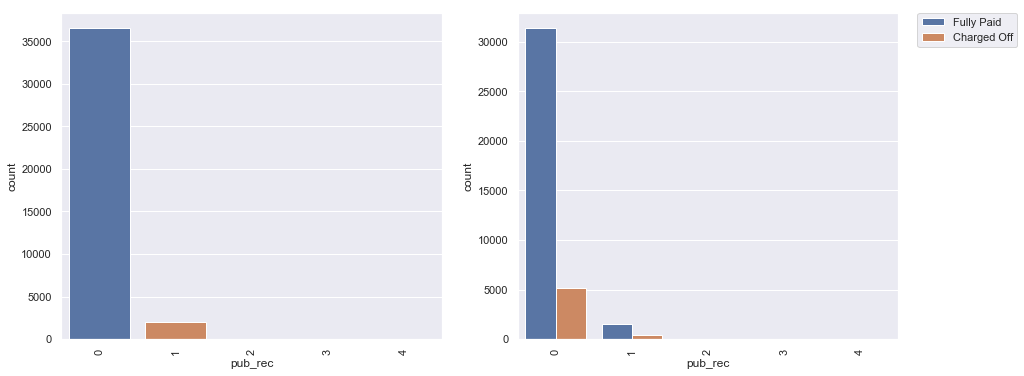

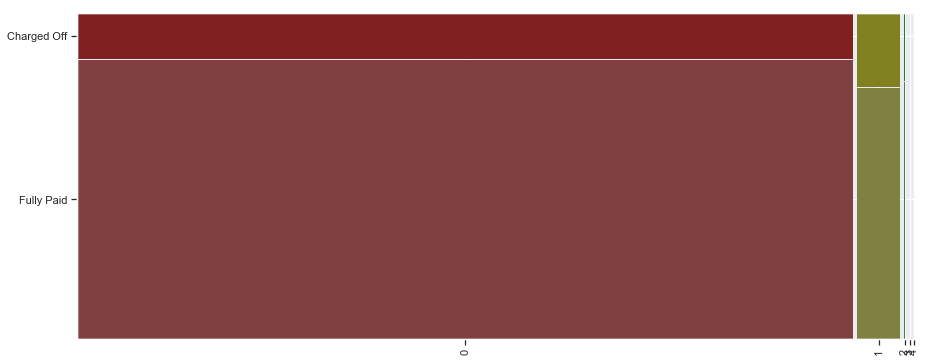

In [146]:
uni_analysis_cat(loan_df[['pub_rec' , 'loan_status']] , summary = True)

### term

Variable = term
Mean Value  41.9
Median  36.0
****************************************************************************************************


C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


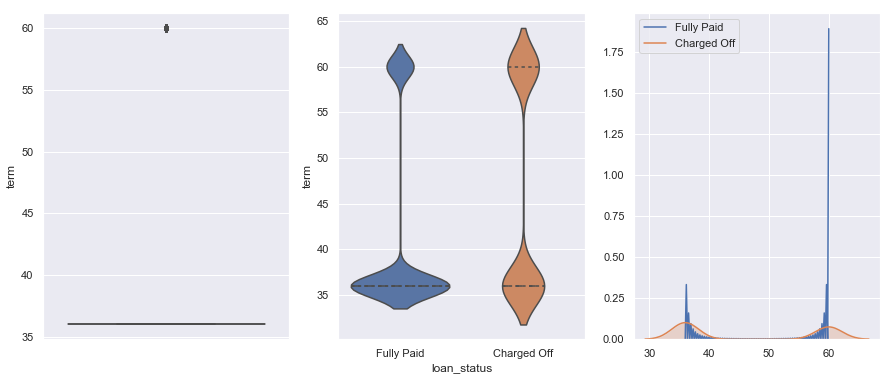

In [147]:
uni_analysis_num(loan_df[['term' , 'loan_status']])